# Homework 3: Questions 1 & 2

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Functions for plotting, do not need to change

def set_spines_invisible(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

def set_grid_invisible(ax):
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

def common_label(fig, xlabel, ylabel):
    """Put a common `xlabel` and `ylabel` on the figure `fig`.
    
    Args:
        - fig (plt.figure)
        - xlabel (str)
        - ylabel (str)
    """
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

## Question 1

In [7]:
# Load data

X_real = np.load("HW3-data/hw3-q1_train.npy")
num_trials = 91
num_class = 8

### Q1(a)

Plot the square-root of the eigenvalues of the data covariance matrix, sorted in decreasing order. The values indicate the standard deviation of the high-dimensional data along each of the principal component directions.

Optional: Note that the square root eigenvalues are the singular values of a simple transformation of the data matrix. If you like, you may use SVD instead of eigenvalue decomposition for this question, but make sure you are taking the SVD of the correct matrix! Hint: write out the sample covariance as a function of the original data matrix.

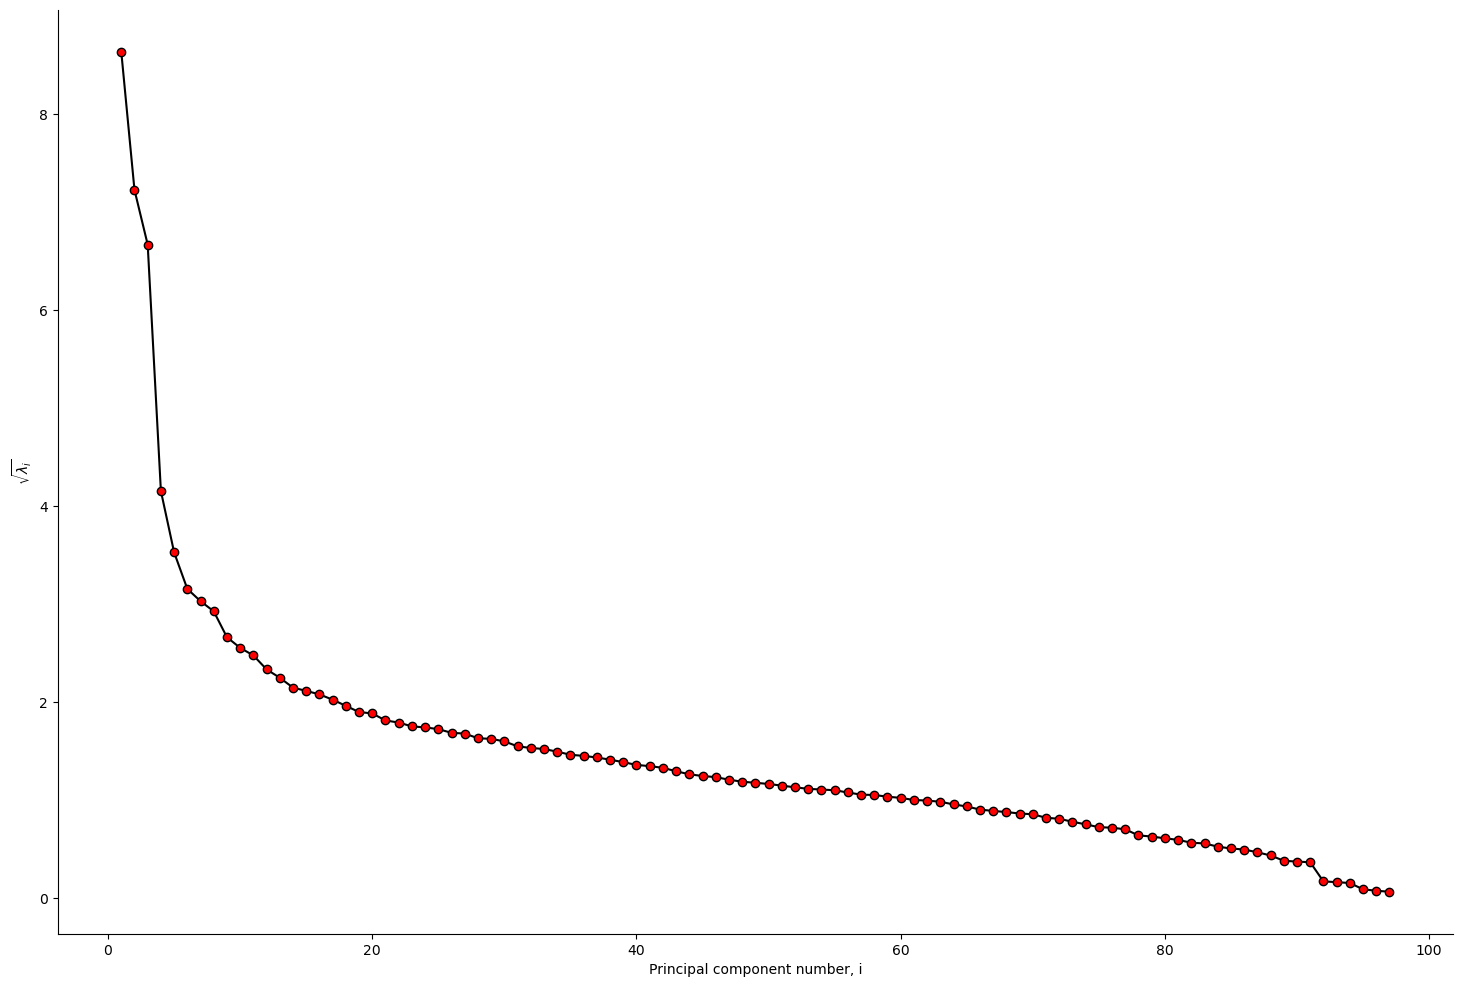

In [ ]:
# ----- YOUR CODE HERE ----- #
cov = np.cov(X_real, rowvar=False)
eigvals = np.sort(np.linalg.eigvals(cov))[::-1]
sqrt_eigvals = np.sqrt(eigvals)
# -------------------------- #

num_neurons = 97
PC_numbers = np.arange(1,num_neurons+1)

fig, ax = plt.subplots(1, 1, figsize=(18, 12))
ax.plot(PC_numbers, sqrt_eigvals, c="k", marker="o", mfc="r", mec="k")
ax.set_ylabel(r"$\sqrt{\lambda_i}$")  
ax.set_xlabel("Principal component number, i")
set_spines_invisible(ax)
plt.show()

In [25]:
# ----- YOUR CODE HERE ----- #
r = 8 # number of dominant singular values
explained_var = sum(eigvals[:r])/sum(eigvals) # explained variance of top r singular values
# -------------------------- #

print(f"There appears to be an elbow after the {r}th dominant singular value. The top {r} singular values explain {explained_var*100:.2f}% of the data variance.")

There appears to be an elbow after the 8th dominant singular value. The top 8 singular values explain 59.87% of the data variance.


### Q1(b)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# ----- YOUR CODE HERE ----- #
# 
# -------------------------- #

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
set_grid_invisible(ax)

# ----- YOUR CODE HERE ----- #
# Find the rotation angle that best separates the clusters
# 
# -------------------------- #

plt.show()

### Q1(c)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# ----- YOUR CODE HERE ----- #
# Use "coolwarm" as your cmap
# 
# -------------------------- #

ax.set_xlabel("neuron #")
ax.set_ylabel("principal component #")
plt.show()

In [ ]:
# ----- YOUR CODE HERE ----- #
ans = NotImplemented
# -------------------------- #

print(f"Are there groupings? \nA: {ans}")

## Question 2

In [ ]:
# Load data

X_sim = np.load("data/hw3-q2_sim.npy")
N, p = X_sim.shape

### Q2(a)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# ----- YOUR CODE HERE ----- #
# 
# -------------------------- #

ax.set_title("PCA projection")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
set_spines_invisible(ax)
plt.ylim(5, 22)
plt.show()

### Q2(b)

Notations used in the code below:
$\begin{equation}
x_n = Wz_n + \mu + \epsilon_n,\ \ \epsilon_n \sim \mathcal{N}(0, \Psi)
\end{equation}$
where the variable for $\mu$ is named ``mu``, $\Psi$ is denoted as ``Psi``, etc.

In [ ]:
# ----- YOUR CODE HERE ----- #
def em_algorithm(X: np.array, zDim: int, typ: str = "FA", tol: float = 1e-8, cyc: int = int(1e8), minVarFrac: float = 0.01, verbose: bool = True):
    """
    Performs EM algorithm for FA or PPCA.

    Args:
        X: data matrix, shape = (xDim, num_trials)
        zDim: dimension of latent factors
        typ: type of analysis, "FA" or "PPCA"
        tol: stopping criterion for EM algorithm
        cyc: maximum number of EM iterations
        minVarFrac: fraction of overall data variance for each observed dimension
            to set as the private variance floor.  This is used to combat 
            Heywood cases, where ML parameter learning returns one or more 
            zero private variances.
            (See Martin & McDonald, Psychometrika, Dec 1975.)
        verbose: whether to display status message
    Returns:
        estParams (dict): estimated parameters, keys: "W", "Psi", "mu"
            W: Loadings matrix, shape = (xDim, zDim)
            Psi: Diagonal of the observation noise covariance, shape = (xDim)
                Note: For PPCA, all elements of Psi should be the same (\sigma^2).
                      For FA, each element may be different (Psi[i] = \sigma^2_i).
            mu: The empirical data mean, shape = (xDim)
        LL (array-like): log-likelihood values for each EM iteration.
    """
    
    # Set random seed for reproducibility
    np.random.seed(0)
    
    # Initialization of parameters
    xDim, N = X.shape
    cX = np.cov(X, ddof=0)
    scale = np.mean(np.diag(cX))
    W = np.random.randn(xDim, zDim) * np.sqrt(scale/zDim)
    Psi = np.diag(cX)
    mu = np.mean(X, axis=1)
    varFloor = minVarFrac * np.diag(cX)
    
    # Set up log-likelihood
    LLi = 0
    LL = []
    
    # EM iterations loop
    for i in range(1, cyc+1):
        
        # Compute data log likelihood
        LLold = LLi
        # **********************************************************************
        # YOUR CODE HERE
        # LLi = ?? # Log likelihood of the data under the iteration i parameters
        raise NotImplementedError
        # **********************************************************************

        if verbose:
            print(f"Iteration {i}: LL {LLi}")
        LL.append(LLi)
        
        # E-step
        # **********************************************************************
        # YOUR CODE HERE
        raise NotImplementedError
        # **********************************************************************
        
        # M-step
        # **********************************************************************
        # YOUR CODE HERE
        # W = ??
        # Psi = ??
        raise NotImplementedError
        # **********************************************************************

        if typ == "PPCA":
            ss = np.maximum(varFloor, np.mean(Psi))
            Psi = ss * np.ones(xDim)
        elif typ == "FA":
            Psi = np.maximum(varFloor, Psi)
        else:
            raise ValueError(f"``typ`` {typ} is not supported.")

        # Termination criterion
        if i <= 2: # Guarantees that we do at least two EM iterations
            LLbase = LLi
        elif LLi < LLold: # Determine whether there are ever likelihood violations
            print('VIOLATION')
        elif (LLi - LLbase) < (1 + tol) * (LLold - LLbase): # Terminate EM
            break

    if np.any(Psi == varFloor):
        print('Warning: Private variance floor used for one or more observed dimensions in FA.')
    
    estParams = {'W': W, 'Psi': Psi, 'mu': mu}
    return estParams, LL
# -------------------------- #

In [ ]:
# ----- YOUR CODE HERE ----- # 
ppca_est, ppca_ll = NotImplemented
# -------------------------- #

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(ppca_ll, "b")
ax.set_xlabel("iteration")
ax.set_ylabel("LL")
ax.set_title("PPCA Log-likelihood")
set_spines_invisible(ax)
plt.show()

### Q2(c)

In [ ]:
# ----- YOUR CODE HERE ----- # 

# The sample constrained covariance estimated by PPCA (i.e., the modeled cov[x])
C = NotImplemented

# The empirical data covariance
S = NotImplemented
# -------------------------- #

print("The observation noise variances estimated by PPCA are: ")
print(Psi)
print("\nThe sample covariance estimated by PPCA is: ")
print(C)
print("\nThis should be very close to the empirical data covariance: ")
print(S)

### Q2(d)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# ----- YOUR CODE HERE ----- #
#
# -------------------------- #

ax.set_title("PPCA projection")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
set_spines_invisible(ax)
plt.show()

### Q2(e)

In [ ]:
# ----- YOUR CODE HERE ----- # 
fa_est, fa_ll = NotImplemented
# -------------------------- #

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(fa_ll, "b")
ax.set_xlabel("iteration")
ax.set_ylabel("LL")
ax.set_title("FA Log-likelihood")
set_spines_invisible(ax)
plt.show()

### Q2(f)

In [ ]:
# ----- YOUR CODE HERE ----- # 

# The sample constrained covariance estimated by PPCA (i.e., the modeled cov[x])
C = NotImplemented

# The empirical data covariance
S = NotImplemented
# -------------------------- #

print("The observation noise variances estimated by FA are: ")
print(Psi)
print("\nThe sample covariance estimated by FA is: ")
print(C)
print("\nThis should be very close to the empirical data covariance: ")
print(S)

### Q2(g)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# ----- YOUR CODE HERE ----- #
# 
# -------------------------- #

ax.set_title("FA projection")
set_spines_invisible(ax)
plt.show()